In [86]:
import statistics
import numpy as np
import random
import scipy.stats as sps
import math
import tqdm

In [87]:
def sd_w(x, k):
    """ computes the windsorized standard deviation, called by dqf_outlier
    Input:
        x: list of numeric data values
        k: number of observations at each extreme to alter
    Returns:
        windsorized standard deviation
    """
    k = int(k)
    if k == 0: return np.std(x)
    else: 
        x.sort()
        l1 = [x[k]]*k
        l2 = [x[-k-1]]*k
        l3 = x[k:-k]
        return np.std(np.concatenate((([x[k]]*k),([x[-k-1]]*k),x[k:-k])))


In [88]:
def subsamp_dqf(n_obs, subsample):
    pairs = []
    subsample = int(subsample/2)*2
    for i in range(1,n_obs+1):
        for j in range(i+1,i+int(subsample/2)+1):
            pairs.append((i-1,j*(j<=n_obs)+(j-n_obs)*(j>n_obs)-1))

    return pairs

In [89]:
import csv

with open('2Dtestdata.csv', newline='') as f:
    reader = csv.reader(f)
    data = list(reader)

data = np.array(data)
data = data.astype(np.float)

C:\Users\gtham\AppData\Local\Temp\ipykernel_16088\752669558.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data = data.astype(np.float)


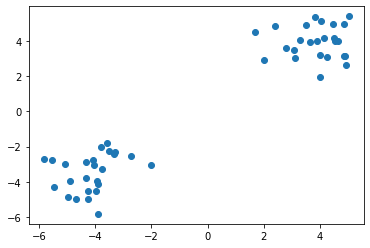

In [90]:
import matplotlib.pyplot as plt

plt.scatter(data[:,0],data[:,1])


In [91]:
param1=0;param2=1
g_scale = 2
angle = [45]
p1 = 1; p2 = 0
n_splits = 100
z_scale = True; k_w = 3; adaptive = True

In [92]:
# shuffle data points
n_obs = len(data)
scram = np.arange(0,n_obs, 1)
random.shuffle(scram)
#   create unscram order array
unscram = np.zeros(len(scram)).astype(int)
for i in range(len(unscram)):
    index = scram[i]
    unscram[index] = int(i)

pairs = subsamp_dqf(n_obs, subsample=50)

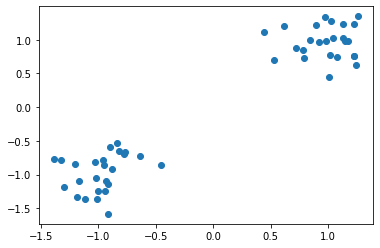

In [93]:
data = sps.zscore(data)
plt.scatter(data[:,0],data[:,1])

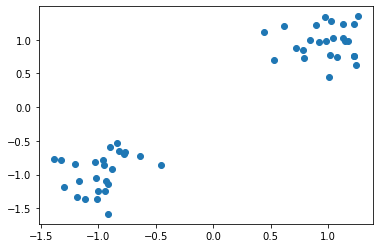

In [94]:
def kern(x,y): return sum(x*y)

data = data[scram,]
gram = np.zeros((n_obs,n_obs))
for i in range(n_obs):
    for j in range(i,n_obs):
        gram[i][j] = kern(data[i,],data[j,])
        gram[j][i] = gram[i][j]

plt.scatter(data[:,0],data[:,1])

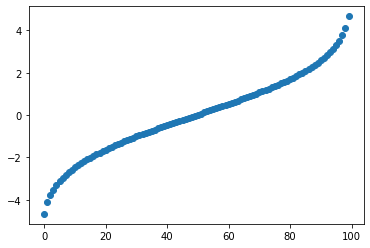

In [95]:
G = "norm"
splits = getattr(sps, G).ppf(np.array(range(1,n_splits+1))/(n_splits+1),param1,param2)*g_scale

plt.scatter(x = range(len(splits)),y=splits)

In [96]:
depthity1 = np.array([0]*len(splits))
norm_k2 = np.array([0 for i in range(n_obs)]); error_k = np.array([0 for i in range(n_obs)]); k_to_mid = np.array([0 for i in range(n_obs)])
dep1 = np.zeros((len(pairs),n_splits))
qfs1 = np.zeros((len(pairs),100))
print(len(pairs))
print(n_splits)

1250
100


In [97]:
for i_sub in tqdm.trange(len(pairs)):
    i = pairs[i_sub][0]; j = pairs[i_sub][1]
    for k in range(n_obs):
        norm_k2[k] = gram[k][k] +.25*(gram[i][i]+gram[j][j]) + .5*gram[i][j] - gram[k][i] - gram[k][j]
        k_to_mid[k] = (gram[k][i]-gram[k][j] + .5*(gram[j][j]-gram[i][i]))/math.sqrt(gram[i][i]+gram[j][j]-2*gram[i][j])
        error_k[k] = math.sqrt(abs(norm_k2[k] - k_to_mid[k]**2))
    for c in range(len(splits)):
        s = splits[c]*(sd_w(k_to_mid,k_w)*adaptive + (not adaptive))
        good = np.array([0 if k_to_mid[i]/s > 1 else 0 for i in range(len(k_to_mid))]) # points on other side of cone tip removed
        d_to_tip = abs(k_to_mid - s)

        good1 = good*(abs(np.vectorize(math.atan)(error_k/k_to_mid)) < (angle[0]/360*2*math.pi))
        good1 = good1*(1-(2*np.sign(k_to_mid)==np.sign(s)))
        depthity1[c] = min(sum([g1==-1 for g1 in good1]),sum([g1==1 for g1 in good1]))
        # same code for depthity2 and depthity3
    
    qfs1[i_sub,] = np.quantile([d for d in depthity1 if not np.isnan(d)], np.linspace(.01,1,100))
dqf1 = np.zeros((n_obs, 100))
for i in range(n_obs):
    dqf1[i] = np.mean(qfs1[np.concatenate((np.where([pair[0] for pair in pairs] == i), np.where([pair[1] for pair in pairs] == i)))])
dqf1 = dqf1[unscram,]

  0%|          | 0/1250 [00:00<?, ?it/s]C:\Users\gtham\AppData\Local\Temp\ipykernel_16088\2633959855.py:12: RuntimeWarning: divide by zero encountered in true_divide
  good1 = good*(abs(np.vectorize(math.atan)(error_k/k_to_mid)) < (angle[0]/360*2*math.pi))
C:\Users\gtham\AppData\Local\Temp\ipykernel_16088\2633959855.py:12: RuntimeWarning: invalid value encountered in true_divide
  good1 = good*(abs(np.vectorize(math.atan)(error_k/k_to_mid)) < (angle[0]/360*2*math.pi))
  1%|          | 13/1250 [00:01<02:45,  7.48it/s]C:\Users\gtham\AppData\Local\Temp\ipykernel_16088\2633959855.py:9: RuntimeWarning: invalid value encountered in true_divide
  good = np.array([0 if k_to_mid[i]/s > 1 else 0 for i in range(len(k_to_mid))]) # points on other side of cone tip removed
  6%|▌         | 75/1250 [00:11<02:50,  6.88it/s]C:\Users\gtham\AppData\Local\Temp\ipykernel_16088\2633959855.py:9: RuntimeWarning: divide by zero encountered in true_divide
  good = np.array([0 if k_to_mid[i]/s > 1 else 0 for i i

In [98]:
dqf1

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])